In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import covasim as cv
from util import data

sns.set_context('notebook')
sns.set_style('whitegrid')

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

cols = ['n_severe', 'n_critical', 'cum_deaths']
n_runs = 3
n_trials = 1000

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


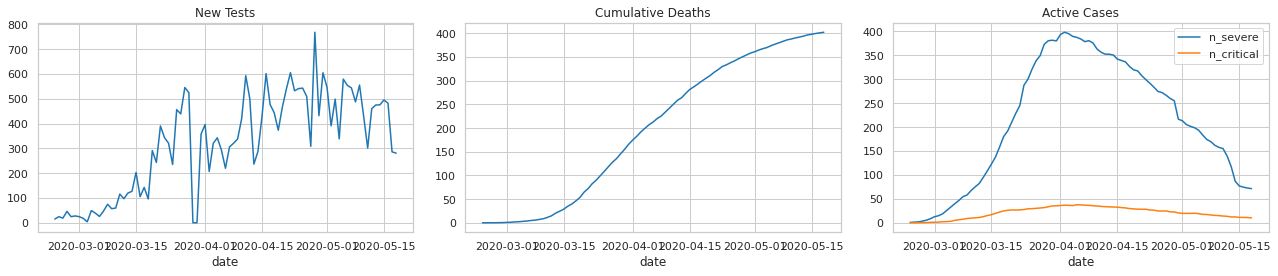

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)
df = df[df['date'] <= pd.to_datetime('2020-05-18')]

_, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_severe', label='n_severe', ax=axes[2]).set(title='Active Cases')
sns.lineplot(data=df, x='date', y='n_critical', label='n_critical', ax=axes[2]).set(ylabel='')

plt.tight_layout()

In [3]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 3.18 / 1e3,
    n_beds_icu=pop_size * 12.5 / 100e3,
    quar_period=14,
    verbose=0
)

In [4]:
import optuna as op
from util.interventions import get_interventions

def unused_param(trial, name, value=0.):
    return trial.suggest_float(name, value, value)

def objective(trial):
    # define learnable parameters
    initial_params = dict(
        pop_infected=trial.suggest_int('init_pop_infected', 1, int(pop_size / 100), step=1),
        n_imports=trial.suggest_float('init_n_imports', 0.0, 10.0, step=1e-1),
        beta=trial.suggest_float('init_beta', 0.0, 0.2, step=1e-3),
        rel_symp_prob=trial.suggest_float('init_rel_symp_prob', 0.01, 10.0, log=True),
        rel_severe_prob=trial.suggest_float('init_rel_severe_prob', 0.01, 10.0, log=True),
        rel_crit_prob=trial.suggest_float('init_rel_crit_prob', 0.01, 10.0, log=True),
        rel_death_prob=trial.suggest_float('init_rel_death_prob', 0.01, 10.0, log=True),
        **default_params
    )
    intervention_params = dict(
        trace_prob=trial.suggest_float('interv_trace_prob', 0.3, 0.9, step=1e-2),           # CONTACT TRACING
        trace_time=trial.suggest_float('interv_trace_time', 1.0, 7.0, step=1e-1),           #
        work_contacts=trial.suggest_float('interv_work_contacts', 0.4, 1.0, step=1e-2),     # SMART WORKING
        school_contacts=trial.suggest_float('interv_school_contacts', 0.2, 0.8, step=1e-2), # SCHOOLS CLOSED
        yellow_contacts=unused_param(trial, 'interv_yellow_contacts'),                      # LOCKDOWN INTERACTIONS
        orange_contacts=unused_param(trial, 'interv_orange_contacts'),                      #
        summer_imports=unused_param(trial, 'interv_summer_imp'),                            # IMPORTED CASES
        yellow_imports=unused_param(trial, 'interv_yellow_imp'),                            #
        orange_imports=unused_param(trial, 'interv_orange_imp'),                            #
        summer_beta=unused_param(trial, 'interv_summer_beta'),                              # VIRAL LOAD REDUCTION
        winter_beta=unused_param(trial, 'interv_winter_beta'),                              #
        summer_symp=unused_param(trial, 'interv_summer_symp'),                              #
        winter_symp=unused_param(trial, 'interv_winter_symp'),                              #
        summer_sev=unused_param(trial, 'interv_summer_sev'),                                #
        winter_sev=unused_param(trial, 'interv_winter_sev'),                                #
        summer_crit=unused_param(trial, 'interv_summer_crit'),                              #
        winter_crit=unused_param(trial, 'interv_winter_crit'),                              #
        summer_death=unused_param(trial, 'interv_summer_death'),                            #
        winter_death=unused_param(trial, 'interv_winter_death')                             #
    )
    # define and run simulations
    sim = cv.Sim(pars=initial_params, interventions=get_interventions(intervention_params), datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    # compute loss
    mismatches = [s.compute_fit(keys=cols, weights={c: 1 for c in cols}).mismatch for s in msim.sims]
    return sum(mismatches) / n_runs

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-11 11:00:52,470] A new study created in memory with name: no-name-076df998-75fb-48f0-8aad-4d7204dd0a8a
[I 2021-03-11 11:01:00,749] Trial 0 finished with value: 1003.6902063457459 and parameters: {'init_pop_infected': 2984, 'init_n_imports': 4.0, 'init_beta': 0.128, 'init_rel_symp_prob': 4.119526879133412, 'init_rel_severe_prob': 0.5815595912516921, 'init_rel_crit_prob': 0.11706006879363699, 'init_rel_death_prob': 0.01496666861000793, 'interv_trace_prob': 0.55, 'interv_trace_time': 6.7, 'interv_work_contacts': 0.5700000000000001, 'interv_school_contacts': 0.46, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 0 with value: 1003.6902

[I 2021-03-11 11:02:04,466] Trial 9 finished with value: 134.5317893156813 and parameters: {'init_pop_infected': 1951, 'init_n_imports': 4.7, 'init_beta': 0.004, 'init_rel_symp_prob': 0.014856815045192597, 'init_rel_severe_prob': 0.09768384903173928, 'init_rel_crit_prob': 5.780463105880022, 'init_rel_death_prob': 1.876214284764192, 'interv_trace_prob': 0.77, 'interv_trace_time': 2.1, 'interv_work_contacts': 0.45, 'interv_school_contacts': 0.78, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 8 with value: 113.89721350119203.
[I 2021-03-11 11:02:11,542] Trial 10 finished with value: 141.5430412707253 and parameters: {'init_pop_infected': 4185

[I 2021-03-11 11:03:07,999] Trial 18 finished with value: 232.06199186564777 and parameters: {'init_pop_infected': 91, 'init_n_imports': 0.5, 'init_beta': 0.094, 'init_rel_symp_prob': 1.9195380203963237, 'init_rel_severe_prob': 0.17464648906381255, 'init_rel_crit_prob': 0.2212606448849154, 'init_rel_death_prob': 0.11255078652943919, 'interv_trace_prob': 0.73, 'interv_trace_time': 4.300000000000001, 'interv_work_contacts': 0.43000000000000005, 'interv_school_contacts': 0.71, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 17 with value: 113.00787231464153.
[I 2021-03-11 11:03:14,687] Trial 19 finished with value: 148.55242981877987 and parame

[I 2021-03-11 11:04:08,454] Trial 27 finished with value: 165.54616438813238 and parameters: {'init_pop_infected': 1423, 'init_n_imports': 5.800000000000001, 'init_beta': 0.146, 'init_rel_symp_prob': 8.776858828827116, 'init_rel_severe_prob': 0.047168076007473594, 'init_rel_crit_prob': 0.3765539311018776, 'init_rel_death_prob': 0.08763183774520214, 'interv_trace_prob': 0.7, 'interv_trace_time': 5.800000000000001, 'interv_work_contacts': 0.48000000000000004, 'interv_school_contacts': 0.74, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 26 with value: 101.65737820614959.
[I 2021-03-11 11:04:15,181] Trial 28 finished with value: 128.7166289220

[I 2021-03-11 11:05:08,231] Trial 36 finished with value: 130.55526543818647 and parameters: {'init_pop_infected': 3252, 'init_n_imports': 4.2, 'init_beta': 0.168, 'init_rel_symp_prob': 9.746537949693613, 'init_rel_severe_prob': 0.020070652587725314, 'init_rel_crit_prob': 0.029864206788298153, 'init_rel_death_prob': 0.2796210449827246, 'interv_trace_prob': 0.64, 'interv_trace_time': 5.5, 'interv_work_contacts': 0.53, 'interv_school_contacts': 0.33, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 26 with value: 101.65737820614959.
[I 2021-03-11 11:05:14,882] Trial 37 finished with value: 113.38176826275583 and parameters: {'init_pop_infected'

[I 2021-03-11 11:06:09,687] Trial 45 finished with value: 1182.2433508606198 and parameters: {'init_pop_infected': 2003, 'init_n_imports': 7.4, 'init_beta': 0.048, 'init_rel_symp_prob': 2.530049871824696, 'init_rel_severe_prob': 0.9986451422876217, 'init_rel_crit_prob': 0.16326839731590964, 'init_rel_death_prob': 0.061888352577166544, 'interv_trace_prob': 0.74, 'interv_trace_time': 5.9, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.44, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 26 with value: 101.65737820614959.
[I 2021-03-11 11:06:16,398] Trial 46 finished with value: 113.95663984031005 and parameters: {'init_pop_infected':

[I 2021-03-11 11:07:09,549] Trial 54 finished with value: 99.78135759045925 and parameters: {'init_pop_infected': 2093, 'init_n_imports': 6.2, 'init_beta': 0.06, 'init_rel_symp_prob': 7.66547902023828, 'init_rel_severe_prob': 0.01578264066931182, 'init_rel_crit_prob': 0.4374229590207647, 'init_rel_death_prob': 0.04921748703167483, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 6.9, 'interv_work_contacts': 0.42000000000000004, 'interv_school_contacts': 0.37, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 54 with value: 99.78135759045925.
[I 2021-03-11 11:07:16,272] Trial 55 finished with value: 102.72947744329504 and parameter

[I 2021-03-11 11:08:16,532] Trial 63 finished with value: 94.09509793963845 and parameters: {'init_pop_infected': 3906, 'init_n_imports': 6.7, 'init_beta': 0.068, 'init_rel_symp_prob': 7.361738986542392, 'init_rel_severe_prob': 0.029124116272819873, 'init_rel_crit_prob': 0.5485184816172524, 'init_rel_death_prob': 2.2943839383582016, 'interv_trace_prob': 0.8999999999999999, 'interv_trace_time': 4.5, 'interv_work_contacts': 0.4, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 62 with value: 85.86893462709725.
[I 2021-03-11 11:08:23,381] Trial 64 finished with value: 86.34999764644665 and parameters: {'init_pop_i

[I 2021-03-11 11:09:17,569] Trial 72 finished with value: 70.39511654234843 and parameters: {'init_pop_infected': 4391, 'init_n_imports': 4.800000000000001, 'init_beta': 0.042, 'init_rel_symp_prob': 1.4764482522893665, 'init_rel_severe_prob': 0.04551763425955417, 'init_rel_crit_prob': 0.7735471377761306, 'init_rel_death_prob': 4.050626630059292, 'interv_trace_prob': 0.8799999999999999, 'interv_trace_time': 3.9000000000000004, 'interv_work_contacts': 0.43000000000000005, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 70 with value: 63.469509331253285.
[I 2021-03-11 11:09:24,538] Trial 73 finished with value: 6

[I 2021-03-11 11:10:19,090] Trial 81 finished with value: 105.40494110084217 and parameters: {'init_pop_infected': 4310, 'init_n_imports': 4.2, 'init_beta': 0.043000000000000003, 'init_rel_symp_prob': 0.9652980047191558, 'init_rel_severe_prob': 0.13014410787679268, 'init_rel_crit_prob': 0.7219479025413866, 'init_rel_death_prob': 7.344508387490232, 'interv_trace_prob': 0.8799999999999999, 'interv_trace_time': 3.4000000000000004, 'interv_work_contacts': 0.46, 'interv_school_contacts': 0.32, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 70 with value: 63.469509331253285.
[I 2021-03-11 11:10:25,954] Trial 82 finished with value: 507.2678017437

[I 2021-03-11 11:11:22,536] Trial 90 finished with value: 138.79072400587526 and parameters: {'init_pop_infected': 3376, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.031, 'init_rel_symp_prob': 2.910134713966199, 'init_rel_severe_prob': 0.10297395715862641, 'init_rel_crit_prob': 1.2987351735725225, 'init_rel_death_prob': 3.1264911601266303, 'interv_trace_prob': 0.8400000000000001, 'interv_trace_time': 1.3, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.34, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:11:30,640] Trial 91 finished with value: 93.80256143571103 and paramete

[I 2021-03-11 11:12:28,448] Trial 99 finished with value: 107.82937074850487 and parameters: {'init_pop_infected': 3247, 'init_n_imports': 3.5, 'init_beta': 0.018000000000000002, 'init_rel_symp_prob': 1.675847202770807, 'init_rel_severe_prob': 0.1140868300047804, 'init_rel_crit_prob': 0.3764197192619799, 'init_rel_death_prob': 6.177648773638648, 'interv_trace_prob': 0.77, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.46, 'interv_school_contacts': 0.33, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:12:35,163] Trial 100 finished with value: 99.49495340500387 and parameters: {'init_pop_

[I 2021-03-11 11:13:30,222] Trial 108 finished with value: 126.18336320483564 and parameters: {'init_pop_infected': 3726, 'init_n_imports': 3.3000000000000003, 'init_beta': 0.007, 'init_rel_symp_prob': 1.0961516551943131, 'init_rel_severe_prob': 0.05625835146127515, 'init_rel_crit_prob': 1.4678243048775816, 'init_rel_death_prob': 8.15422125292311, 'interv_trace_prob': 0.8600000000000001, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.42000000000000004, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:13:37,167] Trial 109 finished with value:

[I 2021-03-11 11:14:31,133] Trial 117 finished with value: 92.3614102845773 and parameters: {'init_pop_infected': 4359, 'init_n_imports': 3.5, 'init_beta': 0.046, 'init_rel_symp_prob': 1.7827304073521502, 'init_rel_severe_prob': 0.08751526298525523, 'init_rel_crit_prob': 0.6477676330957801, 'init_rel_death_prob': 8.94490173791254, 'interv_trace_prob': 0.8600000000000001, 'interv_trace_time': 3.6, 'interv_work_contacts': 0.43000000000000005, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:14:38,287] Trial 118 finished with value: 99.9473919762279

[I 2021-03-11 11:15:35,915] Trial 126 finished with value: 111.14632739292277 and parameters: {'init_pop_infected': 3648, 'init_n_imports': 2.5, 'init_beta': 0.021, 'init_rel_symp_prob': 1.390714002400381, 'init_rel_severe_prob': 0.03371244911474883, 'init_rel_crit_prob': 1.1458982907931492, 'init_rel_death_prob': 3.833268075888305, 'interv_trace_prob': 0.8200000000000001, 'interv_trace_time': 3.5, 'interv_work_contacts': 0.48000000000000004, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:15:42,632] Trial 127 finished with value: 203.21901554187426 and parame

[I 2021-03-11 11:16:36,894] Trial 135 finished with value: 90.36878984768559 and parameters: {'init_pop_infected': 3569, 'init_n_imports': 4.2, 'init_beta': 0.051000000000000004, 'init_rel_symp_prob': 1.1150857122122795, 'init_rel_severe_prob': 0.05045555788778698, 'init_rel_crit_prob': 1.6353426092613716, 'init_rel_death_prob': 5.04044693989224, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.45, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:16:43,825] Trial 136 finished with value: 57.404175841968

[I 2021-03-11 11:17:38,076] Trial 144 finished with value: 108.90319961762502 and parameters: {'init_pop_infected': 4104, 'init_n_imports': 4.7, 'init_beta': 0.013000000000000001, 'init_rel_symp_prob': 1.8153290909001858, 'init_rel_severe_prob': 0.05807249721468538, 'init_rel_crit_prob': 1.214893478846837, 'init_rel_death_prob': 3.6607955919327986, 'interv_trace_prob': 0.8500000000000001, 'interv_trace_time': 2.1, 'interv_work_contacts': 0.53, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:17:44,844] Trial 145 finished with value: 76.76281911914663 and parame

[I 2021-03-11 11:18:41,724] Trial 153 finished with value: 60.75388084994098 and parameters: {'init_pop_infected': 4063, 'init_n_imports': 4.0, 'init_beta': 0.031, 'init_rel_symp_prob': 2.2971774036108332, 'init_rel_severe_prob': 0.06710618913747816, 'init_rel_crit_prob': 0.67928876972992, 'init_rel_death_prob': 4.1688263144707625, 'interv_trace_prob': 0.76, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.47000000000000003, 'interv_school_contacts': 0.28, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:18:48,486] Trial 154 finished with value: 82.2001280523742 and parameters: {'init_pop_

[I 2021-03-11 11:19:43,612] Trial 162 finished with value: 61.287867571872106 and parameters: {'init_pop_infected': 4428, 'init_n_imports': 4.0, 'init_beta': 0.025, 'init_rel_symp_prob': 2.0759774621415548, 'init_rel_severe_prob': 0.08716197030016944, 'init_rel_crit_prob': 0.7870611369518474, 'init_rel_death_prob': 7.05120670979604, 'interv_trace_prob': 0.81, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.5, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 83 with value: 55.88465906618041.
[I 2021-03-11 11:19:50,233] Trial 163 finished with value: 301.97616484532847 and parameters: {'init_po

[I 2021-03-11 11:20:45,865] Trial 171 finished with value: 55.343103429865806 and parameters: {'init_pop_infected': 4493, 'init_n_imports': 3.9000000000000004, 'init_beta': 0.03, 'init_rel_symp_prob': 1.7897519598297158, 'init_rel_severe_prob': 0.07295943329785932, 'init_rel_crit_prob': 1.272680399183182, 'init_rel_death_prob': 5.870315877596974, 'interv_trace_prob': 0.8400000000000001, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.49, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 165 with value: 55.244361525871376.
[I 2021-03-11 11:20:53,042] Trial 172 finished with value: 57.249906390532296 and param

[I 2021-03-11 11:21:48,085] Trial 180 finished with value: 65.85658958877998 and parameters: {'init_pop_infected': 4500, 'init_n_imports': 3.3000000000000003, 'init_beta': 0.021, 'init_rel_symp_prob': 3.034926094687283, 'init_rel_severe_prob': 0.07942484209917972, 'init_rel_crit_prob': 2.289565439584273, 'init_rel_death_prob': 9.082545230178074, 'interv_trace_prob': 0.79, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.5700000000000001, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 173 with value: 51.08523133382547.
[I 2021-03-11 11:21:55,061] Trial 181 finished with value: 52.819816304098

[I 2021-03-11 11:22:50,515] Trial 189 finished with value: 106.7959415547199 and parameters: {'init_pop_infected': 4262, 'init_n_imports': 3.1, 'init_beta': 0.032, 'init_rel_symp_prob': 2.6173676798612266, 'init_rel_severe_prob': 0.05488573874781943, 'init_rel_crit_prob': 3.1835297058570724, 'init_rel_death_prob': 8.745902902227009, 'interv_trace_prob': 0.77, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.51, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 173 with value: 51.08523133382547.
[I 2021-03-11 11:22:57,331] Trial 190 finished with value: 104.73131341007496 and parameters: {'init_

[I 2021-03-11 11:23:54,781] Trial 198 finished with value: 88.38467822996938 and parameters: {'init_pop_infected': 4484, 'init_n_imports': 2.7, 'init_beta': 0.018000000000000002, 'init_rel_symp_prob': 2.7396355038701223, 'init_rel_severe_prob': 0.06272704329392931, 'init_rel_crit_prob': 1.342399502631531, 'init_rel_death_prob': 8.455164577204428, 'interv_trace_prob': 0.8, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.52, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 173 with value: 51.08523133382547.
[I 2021-03-11 11:23:59,842] Trial 199 finished with value: 59.47709175702485 and paramet

[I 2021-03-11 11:24:41,299] Trial 207 finished with value: 69.9530075582937 and parameters: {'init_pop_infected': 4484, 'init_n_imports': 3.3000000000000003, 'init_beta': 0.035, 'init_rel_symp_prob': 3.6384313382665265, 'init_rel_severe_prob': 0.05612356048547457, 'init_rel_crit_prob': 1.2190821856581724, 'init_rel_death_prob': 6.507430363530349, 'interv_trace_prob': 0.6799999999999999, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 173 with value: 51.08523133382547.
[I 2021-03-11 11:24:46,460] Trial 208 finished with value: 62.07688798509293 and paramet

[I 2021-03-11 11:25:27,812] Trial 216 finished with value: 255.02774632513226 and parameters: {'init_pop_infected': 4402, 'init_n_imports': 3.2, 'init_beta': 0.186, 'init_rel_symp_prob': 1.916277586993856, 'init_rel_severe_prob': 0.04883130148048473, 'init_rel_crit_prob': 1.1636458859805323, 'init_rel_death_prob': 8.87401566172277, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.5900000000000001, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 215 with value: 49.873145742751056.
[I 2021-03-11 11:25:33,036] Trial 217 finished with value: 53.1471980712947 and paramete

[I 2021-03-11 11:26:14,980] Trial 225 finished with value: 106.14321368811187 and parameters: {'init_pop_infected': 4404, 'init_n_imports': 2.8000000000000003, 'init_beta': 0.035, 'init_rel_symp_prob': 2.022663295263058, 'init_rel_severe_prob': 0.08171910859881532, 'init_rel_crit_prob': 1.0786202140572283, 'init_rel_death_prob': 8.23161046030571, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.75, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 215 with value: 49.873145742751056.
[I 2021-03-11 11:26:20,287] Trial 226 finished with value: 82.93301537747861 and parame

[I 2021-03-11 11:27:02,553] Trial 234 finished with value: 75.14756806067952 and parameters: {'init_pop_infected': 4327, 'init_n_imports': 2.5, 'init_beta': 0.034, 'init_rel_symp_prob': 1.982904605931534, 'init_rel_severe_prob': 0.06363114721303552, 'init_rel_crit_prob': 1.207844549457083, 'init_rel_death_prob': 6.590570664563869, 'interv_trace_prob': 0.8200000000000001, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 231 with value: 47.27413943309691.
[I 2021-03-11 11:27:07,795] Trial 235 finished with value: 70.85310246197567 and parameters: {'init_pop_

[I 2021-03-11 11:27:49,855] Trial 243 finished with value: 50.38294391775315 and parameters: {'init_pop_infected': 4423, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.027, 'init_rel_symp_prob': 2.880642903494348, 'init_rel_severe_prob': 0.05886242531755615, 'init_rel_crit_prob': 1.3243129352021146, 'init_rel_death_prob': 8.628444480555375, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.26, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 231 with value: 47.27413943309691.
[I 2021-03-11 11:27:55,154] Trial 244 finished with value: 54.01066387868098 and paramet

[I 2021-03-11 11:28:37,410] Trial 252 finished with value: 80.13264175358536 and parameters: {'init_pop_infected': 4358, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.016, 'init_rel_symp_prob': 4.53607764782592, 'init_rel_severe_prob': 0.08048863299197297, 'init_rel_crit_prob': 1.646150674219567, 'init_rel_death_prob': 6.990470853242928, 'interv_trace_prob': 0.81, 'interv_trace_time': 2.4000000000000004, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.25, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 231 with value: 47.27413943309691.
[I 2021-03-11 11:28:42,758] Trial 253 finished with value: 54.00666191391095 and paramete

[I 2021-03-11 11:29:32,702] Trial 262 finished with value: 52.255531769280566 and parameters: {'init_pop_infected': 4497, 'init_n_imports': 2.0, 'init_beta': 0.027, 'init_rel_symp_prob': 2.5169387554185336, 'init_rel_severe_prob': 0.0601765645470578, 'init_rel_crit_prob': 1.1491183637881852, 'init_rel_death_prob': 8.622654977521215, 'interv_trace_prob': 0.48, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 231 with value: 47.27413943309691.
[I 2021-03-11 11:29:38,157] Trial 263 finished with value: 11771.427085249363 and parameters: {'init_p

[I 2021-03-11 11:30:20,390] Trial 271 finished with value: 47.51013945065434 and parameters: {'init_pop_infected': 4495, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 5.434841223369025, 'init_rel_severe_prob': 0.07801474513833971, 'init_rel_crit_prob': 1.0367253158496625, 'init_rel_death_prob': 8.848624866580506, 'interv_trace_prob': 0.52, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:30:25,562] Trial 272 finished with value: 64.54541752008136 and parameters: {'init_po

[I 2021-03-11 11:31:07,640] Trial 280 finished with value: 53.35429295530711 and parameters: {'init_pop_infected': 4343, 'init_n_imports': 2.5, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.554283571634055, 'init_rel_severe_prob': 0.05534452034804644, 'init_rel_crit_prob': 1.2311442488678346, 'init_rel_death_prob': 8.26064447369759, 'interv_trace_prob': 0.44, 'interv_trace_time': 2.4000000000000004, 'interv_work_contacts': 0.76, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:31:12,831] Trial 281 finished with value: 78.65540283690

[I 2021-03-11 11:31:54,886] Trial 289 finished with value: 62.68371652617231 and parameters: {'init_pop_infected': 4265, 'init_n_imports': 1.8, 'init_beta': 0.035, 'init_rel_symp_prob': 5.933765126519049, 'init_rel_severe_prob': 0.05405421556125292, 'init_rel_crit_prob': 0.8315188161786287, 'init_rel_death_prob': 8.95922775330716, 'interv_trace_prob': 0.4, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.77, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:32:00,253] Trial 290 finished with value: 59.479601103059366 and parameters: {'init_pop

[I 2021-03-11 11:32:47,332] Trial 299 finished with value: 113.28553156381751 and parameters: {'init_pop_infected': 1209, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.021, 'init_rel_symp_prob': 4.902596464870699, 'init_rel_severe_prob': 0.043352859300657444, 'init_rel_crit_prob': 1.2538064408197516, 'init_rel_death_prob': 9.915538289240382, 'interv_trace_prob': 0.48, 'interv_trace_time': 2.4000000000000004, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:32:52,621] Trial 300 finished with value: 78.04227655448982 and para

[I 2021-03-11 11:33:34,216] Trial 308 finished with value: 107.8155043504659 and parameters: {'init_pop_infected': 4209, 'init_n_imports': 2.2, 'init_beta': 0.032, 'init_rel_symp_prob': 5.675224494878081, 'init_rel_severe_prob': 0.06072884547808635, 'init_rel_crit_prob': 1.8758911486650367, 'init_rel_death_prob': 7.724856499625026, 'interv_trace_prob': 0.38, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.73, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:33:39,589] Trial 309 finished with value: 62.666455822521804 and parameters: {'init_pop_infected': 4

[I 2021-03-11 11:34:26,645] Trial 318 finished with value: 130.9265460398992 and parameters: {'init_pop_infected': 4192, 'init_n_imports': 2.6, 'init_beta': 0.035, 'init_rel_symp_prob': 4.463398356678206, 'init_rel_severe_prob': 0.07739840186327664, 'init_rel_crit_prob': 1.3481833956568197, 'init_rel_death_prob': 7.609416793691325, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 2.4000000000000004, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:34:31,935] Trial 319 finished with value: 56.67113214142

[I 2021-03-11 11:35:13,918] Trial 327 finished with value: 108.14433561127778 and parameters: {'init_pop_infected': 4498, 'init_n_imports': 2.7, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 4.463115821264977, 'init_rel_severe_prob': 0.08475817708716893, 'init_rel_crit_prob': 1.8368398827576111, 'init_rel_death_prob': 8.044381591574037, 'interv_trace_prob': 0.42, 'interv_trace_time': 2.4000000000000004, 'interv_work_contacts': 0.73, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:35:19,024] Trial 328 finished with value: 75.690152113

[I 2021-03-11 11:36:00,205] Trial 336 finished with value: 62.104472310902985 and parameters: {'init_pop_infected': 4415, 'init_n_imports': 3.1, 'init_beta': 0.034, 'init_rel_symp_prob': 0.42739406287369364, 'init_rel_severe_prob': 0.09891467897797829, 'init_rel_crit_prob': 1.6205077786446072, 'init_rel_death_prob': 8.71262762557894, 'interv_trace_prob': 0.5, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.76, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:36:05,323] Trial 337 finished with value: 129.45326283756853 and parameters: {'init_

[I 2021-03-11 11:36:47,309] Trial 345 finished with value: 73.01164448669358 and parameters: {'init_pop_infected': 4271, 'init_n_imports': 2.5, 'init_beta': 0.025, 'init_rel_symp_prob': 7.484557146077863, 'init_rel_severe_prob': 0.046068580321315195, 'init_rel_crit_prob': 1.0804203200816758, 'init_rel_death_prob': 8.904625278006721, 'interv_trace_prob': 0.8200000000000001, 'interv_trace_time': 2.3, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.5700000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:36:52,493] Trial 346 finished with value: 60.670887171111225 and parame

[I 2021-03-11 11:37:34,520] Trial 354 finished with value: 260.21063360985397 and parameters: {'init_pop_infected': 4291, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.129, 'init_rel_symp_prob': 2.5356012889044086, 'init_rel_severe_prob': 0.044674400975521, 'init_rel_crit_prob': 1.502403906494395, 'init_rel_death_prob': 6.484306522241087, 'interv_trace_prob': 0.78, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:37:39,693] Trial 355 finished with value: 123.65737497213252 and parameters: {'init_po

[I 2021-03-11 11:38:21,480] Trial 363 finished with value: 77.37269289428811 and parameters: {'init_pop_infected': 4496, 'init_n_imports': 3.2, 'init_beta': 0.022, 'init_rel_symp_prob': 3.9923108209570812, 'init_rel_severe_prob': 0.08211925129684057, 'init_rel_crit_prob': 2.2582714494098934, 'init_rel_death_prob': 6.346559592393125, 'interv_trace_prob': 0.48, 'interv_trace_time': 2.2, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:38:26,820] Trial 364 finished with value: 58.781112292284945 and parameters: {'init_pop_infected': 4

[I 2021-03-11 11:39:13,693] Trial 373 finished with value: 56.456171193147036 and parameters: {'init_pop_infected': 4414, 'init_n_imports': 3.3000000000000003, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 7.65365493258312, 'init_rel_severe_prob': 0.07989821497715781, 'init_rel_crit_prob': 1.262863355359143, 'init_rel_death_prob': 6.21220403004155, 'interv_trace_prob': 0.55, 'interv_trace_time': 1.9, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:39:19,229] Trial 374 finished with value: 154.24973127528

[I 2021-03-11 11:40:01,695] Trial 382 finished with value: 60.60019519333179 and parameters: {'init_pop_infected': 2523, 'init_n_imports': 1.8, 'init_beta': 0.033, 'init_rel_symp_prob': 5.835551573847582, 'init_rel_severe_prob': 0.04168436903821923, 'init_rel_crit_prob': 1.5221145409690204, 'init_rel_death_prob': 7.0930242937904335, 'interv_trace_prob': 0.8400000000000001, 'interv_trace_time': 3.3000000000000003, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:40:06,946] Trial 383 finished with value: 71.94080237604952 and paramet

[I 2021-03-11 11:40:49,470] Trial 391 finished with value: 76.17054839122791 and parameters: {'init_pop_infected': 4430, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.025, 'init_rel_symp_prob': 5.957706845772329, 'init_rel_severe_prob': 0.08155114965423431, 'init_rel_crit_prob': 1.6217346882300543, 'init_rel_death_prob': 6.969837973156216, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.76, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:40:55,013] Trial 392 finished with value: 90.866113227974

[I 2021-03-11 11:41:38,385] Trial 400 finished with value: 50.173703981125236 and parameters: {'init_pop_infected': 4421, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.032, 'init_rel_symp_prob': 2.595670954519996, 'init_rel_severe_prob': 0.0712195516818795, 'init_rel_crit_prob': 1.0021080501014175, 'init_rel_death_prob': 8.96058382198873, 'interv_trace_prob': 0.39, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 270 with value: 43.96719299885839.
[I 2021-03-11 11:41:43,769] Trial 401 finished with value: 63.25648276979478 and paramete

[I 2021-03-11 11:42:26,894] Trial 409 finished with value: 73.87795584126987 and parameters: {'init_pop_infected': 4495, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.04, 'init_rel_symp_prob': 2.0247136255648233, 'init_rel_severe_prob': 0.06587798968273546, 'init_rel_crit_prob': 0.8488663743712647, 'init_rel_death_prob': 9.98933457332152, 'interv_trace_prob': 0.36, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.21000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 404 with value: 43.829848715729106.
[I 2021-03-11 11:42:32,302] Trial 410 finished with value: 50.338618640393825 and param

[I 2021-03-11 11:43:20,873] Trial 419 finished with value: 111.83511778695697 and parameters: {'init_pop_infected': 4188, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.035, 'init_rel_symp_prob': 0.34196344613095514, 'init_rel_severe_prob': 0.07330930392025088, 'init_rel_crit_prob': 0.3329107150346806, 'init_rel_death_prob': 5.6919425586926335, 'interv_trace_prob': 0.37, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 404 with value: 43.829848715729106.
[I 2021-03-11 11:43:26,256] Trial 420 finished with value: 94.24127260144753 and p

[I 2021-03-11 11:44:08,498] Trial 428 finished with value: 116.0101490306556 and parameters: {'init_pop_infected': 4372, 'init_n_imports': 1.5, 'init_beta': 0.009000000000000001, 'init_rel_symp_prob': 4.171930442632049, 'init_rel_severe_prob': 0.07901265550691558, 'init_rel_crit_prob': 0.8590342730829822, 'init_rel_death_prob': 5.279474753789414, 'interv_trace_prob': 0.5, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 404 with value: 43.829848715729106.
[I 2021-03-11 11:44:13,912] Trial 429 finished with value: 64.11878374150119 and parameters: {'init_pop

[I 2021-03-11 11:44:56,866] Trial 437 finished with value: 888.1001666208812 and parameters: {'init_pop_infected': 4160, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 5.896458888876789, 'init_rel_severe_prob': 0.5196134906404538, 'init_rel_crit_prob': 1.09959976908449, 'init_rel_death_prob': 9.993900068667658, 'interv_trace_prob': 0.47, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 404 with value: 43.829848715729106.
[I 2021-03-11 11:45:02,275] Trial 438 finished with value: 57.37467760660285 and parameters: {'init_pop_i

[I 2021-03-11 11:45:45,284] Trial 446 finished with value: 56.09566947877207 and parameters: {'init_pop_infected': 3991, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.022, 'init_rel_symp_prob': 3.6136225129570976, 'init_rel_severe_prob': 0.1042396000216599, 'init_rel_crit_prob': 0.7978824020775278, 'init_rel_death_prob': 6.247928323159638, 'interv_trace_prob': 0.51, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:45:50,682] Trial 447 finished with value: 94.97406335902947 and parameters: {'init_pop

[I 2021-03-11 11:46:33,679] Trial 455 finished with value: 60.17408053973517 and parameters: {'init_pop_infected': 4013, 'init_n_imports': 1.3, 'init_beta': 0.023, 'init_rel_symp_prob': 4.068734170996971, 'init_rel_severe_prob': 0.07498123629988172, 'init_rel_crit_prob': 0.9147484722998824, 'init_rel_death_prob': 6.14337323161735, 'interv_trace_prob': 0.47, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:46:39,030] Trial 456 finished with value: 98.54112671381336 and parameters: {'init_pop_infected': 4122

[I 2021-03-11 11:47:21,905] Trial 464 finished with value: 57.61374447436407 and parameters: {'init_pop_infected': 4139, 'init_n_imports': 2.2, 'init_beta': 0.035, 'init_rel_symp_prob': 3.835045073742112, 'init_rel_severe_prob': 0.07335738691935817, 'init_rel_crit_prob': 0.8606582717537055, 'init_rel_death_prob': 8.094923948437485, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.6799999999999999, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:47:27,465] Trial 465 finished with value: 63.923508526160106 and paramet

[I 2021-03-11 11:48:14,700] Trial 474 finished with value: 117.25731927228726 and parameters: {'init_pop_infected': 4255, 'init_n_imports': 2.5, 'init_beta': 0.012, 'init_rel_symp_prob': 6.841890962702442, 'init_rel_severe_prob': 0.08462524555479016, 'init_rel_crit_prob': 0.1446978394918215, 'init_rel_death_prob': 6.925314819075751, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.55, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:48:19,911] Trial 475 finished with value: 64.06886999836591 and parameters: {'init_pop

[I 2021-03-11 11:49:01,612] Trial 483 finished with value: 54.66782471805241 and parameters: {'init_pop_infected': 4368, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.02, 'init_rel_symp_prob': 4.376869311910263, 'init_rel_severe_prob': 0.07186854669404298, 'init_rel_crit_prob': 1.2588982223010485, 'init_rel_death_prob': 7.847591306495368, 'interv_trace_prob': 0.6, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:49:06,800] Trial 484 finished with value: 2047.5599997500415 and parameters: {'init_pop_

[I 2021-03-11 11:49:48,179] Trial 492 finished with value: 77.33311773037869 and parameters: {'init_pop_infected': 4410, 'init_n_imports': 2.3000000000000003, 'init_beta': 0.021, 'init_rel_symp_prob': 3.75005182336295, 'init_rel_severe_prob': 0.07173983803772856, 'init_rel_crit_prob': 0.4336100813541435, 'init_rel_death_prob': 9.983203641834903, 'interv_trace_prob': 0.51, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6799999999999999, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:49:53,387] Trial 493 finished with value: 66.86879308707739 and parameter

[I 2021-03-11 11:50:35,128] Trial 501 finished with value: 152.65305353179164 and parameters: {'init_pop_infected': 1451, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.036000000000000004, 'init_rel_symp_prob': 5.339261602152599, 'init_rel_severe_prob': 0.11517827274462536, 'init_rel_crit_prob': 1.4349979530173664, 'init_rel_death_prob': 7.513104451241729, 'interv_trace_prob': 0.8700000000000001, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 444 with value: 43.5338464188747.
[I 2021-03-11 11:50:40,391] Trial 502 finished with value: 67.475518608023

[I 2021-03-11 11:51:22,580] Trial 510 finished with value: 97.40342257927468 and parameters: {'init_pop_infected': 4341, 'init_n_imports': 2.4000000000000004, 'init_beta': 0.031, 'init_rel_symp_prob': 3.143181651767947, 'init_rel_severe_prob': 0.08009967582253212, 'init_rel_crit_prob': 1.2680989169998902, 'init_rel_death_prob': 4.860589187248612, 'interv_trace_prob': 0.51, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:51:28,082] Trial 511 finished with value: 21616.01293233728 and parameters: {'init_p

[I 2021-03-11 11:52:15,177] Trial 520 finished with value: 64.95517211815728 and parameters: {'init_pop_infected': 4498, 'init_n_imports': 2.2, 'init_beta': 0.028, 'init_rel_symp_prob': 3.263532795966777, 'init_rel_severe_prob': 0.06862408489043216, 'init_rel_crit_prob': 1.384706027006854, 'init_rel_death_prob': 7.280887225942044, 'interv_trace_prob': 0.52, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:52:20,493] Trial 521 finished with value: 51.64285788943414 and parameters: {'init_pop_infected': 42

[I 2021-03-11 11:53:02,422] Trial 529 finished with value: 65.35844330671982 and parameters: {'init_pop_infected': 4497, 'init_n_imports': 2.0, 'init_beta': 0.035, 'init_rel_symp_prob': 2.548978884719492, 'init_rel_severe_prob': 0.0633907398262379, 'init_rel_crit_prob': 1.000982619843454, 'init_rel_death_prob': 5.766823469857001, 'interv_trace_prob': 0.49, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.5800000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:53:07,435] Trial 530 finished with value: 102.12356357143938 and parameters: {'init_pop_

[I 2021-03-11 11:53:50,203] Trial 538 finished with value: 119.94174392300965 and parameters: {'init_pop_infected': 4496, 'init_n_imports': 2.1, 'init_beta': 0.041, 'init_rel_symp_prob': 2.4846061677530957, 'init_rel_severe_prob': 0.07500306389157362, 'init_rel_crit_prob': 1.2268999254502833, 'init_rel_death_prob': 9.925149503654927, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.45, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:53:55,548] Trial 539 finished with value: 87.41648493241986 and parameters: {'init

[I 2021-03-11 11:54:37,704] Trial 547 finished with value: 423.512816430303 and parameters: {'init_pop_infected': 4417, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.195, 'init_rel_symp_prob': 4.098935272772158, 'init_rel_severe_prob': 0.06557804144320269, 'init_rel_crit_prob': 0.9152164372947159, 'init_rel_death_prob': 0.01196065732486492, 'interv_trace_prob': 0.37, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:54:42,852] Trial 548 finished with value: 57.93850610673669 and parameters: {'init_p

[I 2021-03-11 11:55:25,154] Trial 556 finished with value: 67.63472085799032 and parameters: {'init_pop_infected': 4386, 'init_n_imports': 2.0, 'init_beta': 0.043000000000000003, 'init_rel_symp_prob': 6.978026571075506, 'init_rel_severe_prob': 0.05309115274336269, 'init_rel_crit_prob': 0.9017699711789644, 'init_rel_death_prob': 8.477290776371918, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.24000000000000002, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:55:30,513] Trial 557 finished with value: 86.0251647431

[I 2021-03-11 11:56:12,397] Trial 565 finished with value: 674.4810479218081 and parameters: {'init_pop_infected': 4361, 'init_n_imports': 2.7, 'init_beta': 0.033, 'init_rel_symp_prob': 6.902219176022833, 'init_rel_severe_prob': 0.3423103508695936, 'init_rel_crit_prob': 1.0527289077467494, 'init_rel_death_prob': 5.761386369220436, 'interv_trace_prob': 0.8300000000000001, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.71, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:56:17,751] Trial 566 finished with value: 61.29705993289881 and parameters: {'init_pop

[I 2021-03-11 11:56:59,429] Trial 574 finished with value: 71.09675914223472 and parameters: {'init_pop_infected': 4238, 'init_n_imports': 2.8000000000000003, 'init_beta': 0.023, 'init_rel_symp_prob': 3.857835373829172, 'init_rel_severe_prob': 0.04598068913190311, 'init_rel_crit_prob': 1.266327763316022, 'init_rel_death_prob': 7.072076679654377, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.23, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:57:04,836] Trial 575 finished with value: 69.44806119312123 and parame

[I 2021-03-11 11:57:46,402] Trial 583 finished with value: 201.4475217056181 and parameters: {'init_pop_infected': 4500, 'init_n_imports': 2.2, 'init_beta': 0.061, 'init_rel_symp_prob': 5.141497313721571, 'init_rel_severe_prob': 0.10228486754333153, 'init_rel_crit_prob': 0.8397648740758418, 'init_rel_death_prob': 7.648560758983382, 'interv_trace_prob': 0.8600000000000001, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.27, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:57:51,741] Trial 584 finished with value: 137.45280906624546 and parameters: {'init_p

[I 2021-03-11 11:58:33,776] Trial 592 finished with value: 70.87517560656404 and parameters: {'init_pop_infected': 2475, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.033, 'init_rel_symp_prob': 4.291317497557309, 'init_rel_severe_prob': 0.0353890293747538, 'init_rel_crit_prob': 1.0666161066606386, 'init_rel_death_prob': 4.489924014707139, 'interv_trace_prob': 0.8200000000000001, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.63, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:58:39,011] Trial 593 finished with value: 59.839852401737325 and paramet

[I 2021-03-11 11:59:20,225] Trial 601 finished with value: 123.49550030432938 and parameters: {'init_pop_infected': 3327, 'init_n_imports': 1.3, 'init_beta': 0.008, 'init_rel_symp_prob': 5.72468382184113, 'init_rel_severe_prob': 0.12329880353765019, 'init_rel_crit_prob': 0.5613979856433311, 'init_rel_death_prob': 3.8083643789178026, 'interv_trace_prob': 0.48, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 11:59:25,255] Trial 602 finished with value: 89.7263790233629 and parameters: {'init_pop_infected': 40

[I 2021-03-11 12:00:06,257] Trial 610 finished with value: 51.890458661116234 and parameters: {'init_pop_infected': 4082, 'init_n_imports': 1.6, 'init_beta': 0.024, 'init_rel_symp_prob': 5.885943295821602, 'init_rel_severe_prob': 0.09359213234384486, 'init_rel_crit_prob': 0.887225839722754, 'init_rel_death_prob': 4.797914537460457, 'interv_trace_prob': 0.44, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 12:00:11,457] Trial 611 finished with value: 80.94694339318518 and parameters: {'init_pop_infected': 40

[I 2021-03-11 12:00:53,121] Trial 619 finished with value: 45.747372054320294 and parameters: {'init_pop_infected': 3898, 'init_n_imports': 1.6, 'init_beta': 0.022, 'init_rel_symp_prob': 7.108877111407604, 'init_rel_severe_prob': 0.10024007133833682, 'init_rel_crit_prob': 1.2129191321878177, 'init_rel_death_prob': 6.189292577503299, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 3.4000000000000004, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.22, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 12:00:58,056] Trial 620 finished with value: 93.50866698655477 and para

[I 2021-03-11 12:01:38,812] Trial 628 finished with value: 165.1926427590782 and parameters: {'init_pop_infected': 3771, 'init_n_imports': 0.9, 'init_beta': 0.022, 'init_rel_symp_prob': 9.948751998262523, 'init_rel_severe_prob': 0.1992543103578354, 'init_rel_crit_prob': 1.467619060130947, 'init_rel_death_prob': 5.853311967874251, 'interv_trace_prob': 0.43, 'interv_trace_time': 3.6, 'interv_work_contacts': 0.66, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 12:01:44,011] Trial 629 finished with value: 66.0542989117338 and parameters: {'init_pop_infected': 3864

[I 2021-03-11 12:02:25,441] Trial 637 finished with value: 53.4620216788418 and parameters: {'init_pop_infected': 4081, 'init_n_imports': 1.8, 'init_beta': 0.021, 'init_rel_symp_prob': 8.622320810666817, 'init_rel_severe_prob': 0.09565617660977299, 'init_rel_crit_prob': 1.349756333578881, 'init_rel_death_prob': 4.787659326647744, 'interv_trace_prob': 0.47, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 509 with value: 42.630479861176404.
[I 2021-03-11 12:02:30,341] Trial 638 finished with value: 121.61864783542943 and parameters: {'init_pop_infected': 32

[I 2021-03-11 12:03:11,361] Trial 646 finished with value: 86.3477221401057 and parameters: {'init_pop_infected': 3272, 'init_n_imports': 0.4, 'init_beta': 0.013000000000000001, 'init_rel_symp_prob': 8.766119173523528, 'init_rel_severe_prob': 0.22811401784241125, 'init_rel_crit_prob': 0.8804091135831664, 'init_rel_death_prob': 5.4234627943468166, 'interv_trace_prob': 0.43, 'interv_trace_time': 3.3000000000000003, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:03:16,571] Trial 647 finished with value: 52.292560213543204 and param

[I 2021-03-11 12:03:57,354] Trial 655 finished with value: 102.17145403780546 and parameters: {'init_pop_infected': 2827, 'init_n_imports': 1.1, 'init_beta': 0.015, 'init_rel_symp_prob': 7.229731119085378, 'init_rel_severe_prob': 0.11180387510446535, 'init_rel_crit_prob': 0.9511101530421948, 'init_rel_death_prob': 4.813020020063064, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.5900000000000001, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:04:02,553] Trial 656 finished with value: 53.26652520619107 and parame

[I 2021-03-11 12:04:43,546] Trial 664 finished with value: 116.48362550663028 and parameters: {'init_pop_infected': 2752, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.011, 'init_rel_symp_prob': 8.469955530602864, 'init_rel_severe_prob': 0.15020737641349244, 'init_rel_crit_prob': 0.7247328099425615, 'init_rel_death_prob': 6.759711084311876, 'interv_trace_prob': 0.47, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.6000000000000001, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:04:48,784] Trial 665 finished with value: 66.79383017197479 and parame

[I 2021-03-11 12:05:29,868] Trial 673 finished with value: 131.89596135160556 and parameters: {'init_pop_infected': 2872, 'init_n_imports': 1.1, 'init_beta': 0.027, 'init_rel_symp_prob': 5.4962062795538085, 'init_rel_severe_prob': 0.0802055262415725, 'init_rel_crit_prob': 1.3009343411516245, 'init_rel_death_prob': 0.7713349356487569, 'interv_trace_prob': 0.48, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:05:34,927] Trial 674 finished with value: 89.82545914291306 and parameters: {'init_pop_infected': 

[I 2021-03-11 12:06:16,968] Trial 682 finished with value: 61.21731461681583 and parameters: {'init_pop_infected': 3159, 'init_n_imports': 1.8, 'init_beta': 0.024, 'init_rel_symp_prob': 4.819468428246161, 'init_rel_severe_prob': 0.08115715952354387, 'init_rel_crit_prob': 0.7216751765151239, 'init_rel_death_prob': 7.402718687839501, 'interv_trace_prob': 0.41, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.61, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:06:22,191] Trial 683 finished with value: 93.404572417995 and parameters: {'init_pop_

[I 2021-03-11 12:07:03,163] Trial 691 finished with value: 73.80221476883513 and parameters: {'init_pop_infected': 3187, 'init_n_imports': 0.8, 'init_beta': 0.018000000000000002, 'init_rel_symp_prob': 9.940557614512903, 'init_rel_severe_prob': 0.13719345554146722, 'init_rel_crit_prob': 0.7837054917109513, 'init_rel_death_prob': 5.138113197072983, 'interv_trace_prob': 0.54, 'interv_trace_time': 3.3000000000000003, 'interv_work_contacts': 0.54, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:07:08,192] Trial 692 finished with value: 91.19940691347585 and parame

[I 2021-03-11 12:07:48,322] Trial 700 finished with value: 57.96525100082622 and parameters: {'init_pop_infected': 3525, 'init_n_imports': 0.8, 'init_beta': 0.019, 'init_rel_symp_prob': 6.985833146951883, 'init_rel_severe_prob': 0.1693586568233385, 'init_rel_crit_prob': 0.7443940321966844, 'init_rel_death_prob': 5.568501885706478, 'interv_trace_prob': 0.51, 'interv_trace_time': 3.7, 'interv_work_contacts': 0.56, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:07:53,451] Trial 701 finished with value: 54.48920149190218 and parameters: {'init_pop_infected': 311

[I 2021-03-11 12:08:34,330] Trial 709 finished with value: 2025.7664067271162 and parameters: {'init_pop_infected': 3009, 'init_n_imports': 1.5, 'init_beta': 0.134, 'init_rel_symp_prob': 7.213452540562559, 'init_rel_severe_prob': 0.1612233893982891, 'init_rel_crit_prob': 5.580216299604429, 'init_rel_death_prob': 0.021042380578313587, 'interv_trace_prob': 0.53, 'interv_trace_time': 3.4000000000000004, 'interv_work_contacts': 0.56, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:08:39,630] Trial 710 finished with value: 55.13996354816927 and param

[I 2021-03-11 12:09:19,498] Trial 718 finished with value: 116.22271594088356 and parameters: {'init_pop_infected': 3297, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.007, 'init_rel_symp_prob': 7.474106662880148, 'init_rel_severe_prob': 0.18580058958494364, 'init_rel_crit_prob': 0.8866040138774363, 'init_rel_death_prob': 5.528040774140464, 'interv_trace_prob': 0.56, 'interv_trace_time': 3.6, 'interv_work_contacts': 0.56, 'interv_school_contacts': 0.69, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:09:24,628] Trial 719 finished with value: 92.0862494640517 and parameters: {'init_po

[I 2021-03-11 12:10:05,669] Trial 727 finished with value: 97.65357675918598 and parameters: {'init_pop_infected': 3252, 'init_n_imports': 1.8, 'init_beta': 0.014, 'init_rel_symp_prob': 4.482722596286749, 'init_rel_severe_prob': 0.163295321872512, 'init_rel_crit_prob': 0.8065625625076044, 'init_rel_death_prob': 7.460921200575088, 'interv_trace_prob': 0.52, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.6000000000000001, 'interv_school_contacts': 0.69, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:10:10,796] Trial 728 finished with value: 108.76914074974955 and parameters: {'init_pop_

[I 2021-03-11 12:10:51,927] Trial 736 finished with value: 112.00993528132183 and parameters: {'init_pop_infected': 3193, 'init_n_imports': 0.8, 'init_beta': 0.01, 'init_rel_symp_prob': 4.44821324655448, 'init_rel_severe_prob': 0.10789604881622915, 'init_rel_crit_prob': 1.2030446821425773, 'init_rel_death_prob': 6.64594693137277, 'interv_trace_prob': 0.5700000000000001, 'interv_trace_time': 3.3000000000000003, 'interv_work_contacts': 0.6000000000000001, 'interv_school_contacts': 0.6100000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:10:57,165] Trial 737 finished with value: 65.

[I 2021-03-11 12:11:37,881] Trial 745 finished with value: 98.19257189202894 and parameters: {'init_pop_infected': 3269, 'init_n_imports': 0.6000000000000001, 'init_beta': 0.014, 'init_rel_symp_prob': 4.895447386983374, 'init_rel_severe_prob': 0.09600001209988197, 'init_rel_crit_prob': 1.3180405568319307, 'init_rel_death_prob': 8.38973891586105, 'interv_trace_prob': 0.51, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.55, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:11:43,179] Trial 746 finished with value: 69.09739112213187 and parameters: {'init_pop

[I 2021-03-11 12:12:24,539] Trial 754 finished with value: 118.18897460949404 and parameters: {'init_pop_infected': 3270, 'init_n_imports': 1.3, 'init_beta': 0.033, 'init_rel_symp_prob': 5.321866077974356, 'init_rel_severe_prob': 0.11377287061592531, 'init_rel_crit_prob': 1.0576458282035908, 'init_rel_death_prob': 4.688027678383461, 'interv_trace_prob': 0.51, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.5900000000000001, 'interv_school_contacts': 0.55, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:12:29,473] Trial 755 finished with value: 114.17634265068916 and parameters: {'init_p

[I 2021-03-11 12:13:16,545] Trial 764 finished with value: 97.16540721131501 and parameters: {'init_pop_infected': 3961, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.013000000000000001, 'init_rel_symp_prob': 4.82956332537238, 'init_rel_severe_prob': 0.1314358733394258, 'init_rel_crit_prob': 1.0687217500173276, 'init_rel_death_prob': 5.255324366090836, 'interv_trace_prob': 0.49, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.54, 'interv_school_contacts': 0.75, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:13:21,690] Trial 765 finished with value: 350.65840802422076 and paramet

[I 2021-03-11 12:14:03,401] Trial 773 finished with value: 57.65224294715345 and parameters: {'init_pop_infected': 2160, 'init_n_imports': 1.0, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 0.9292827514316222, 'init_rel_severe_prob': 0.11889879456650375, 'init_rel_crit_prob': 1.1543619316242255, 'init_rel_death_prob': 8.939120211674082, 'interv_trace_prob': 0.48, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.48000000000000004, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:14:08,515] Trial 774 finished with value: 88.42926889510262 and param

[I 2021-03-11 12:14:50,022] Trial 782 finished with value: 50.067923944054456 and parameters: {'init_pop_infected': 4035, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.025, 'init_rel_symp_prob': 8.709497449556798, 'init_rel_severe_prob': 0.07491401845136153, 'init_rel_crit_prob': 0.9632411449691225, 'init_rel_death_prob': 6.508161365852186, 'interv_trace_prob': 0.5, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.53, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:14:55,337] Trial 783 finished with value: 202.361171862798 and parameters: {'init_pop

[I 2021-03-11 12:15:37,291] Trial 791 finished with value: 60.80747585908464 and parameters: {'init_pop_infected': 3029, 'init_n_imports': 1.5, 'init_beta': 0.032, 'init_rel_symp_prob': 5.698475562262573, 'init_rel_severe_prob': 0.07316125025487892, 'init_rel_crit_prob': 0.9274300552680029, 'init_rel_death_prob': 8.10528308945606, 'interv_trace_prob': 0.52, 'interv_trace_time': 6.0, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.35, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:15:42,395] Trial 792 finished with value: 79.97595963147556 and parameters: {'init_pop_infected': 398

[I 2021-03-11 12:16:29,741] Trial 801 finished with value: 102.66520185091377 and parameters: {'init_pop_infected': 4107, 'init_n_imports': 2.0, 'init_beta': 0.033, 'init_rel_symp_prob': 3.9195133454852793, 'init_rel_severe_prob': 0.0727888984982802, 'init_rel_crit_prob': 1.5218237027626789, 'init_rel_death_prob': 4.771836219712827, 'interv_trace_prob': 0.54, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.65, 'interv_school_contacts': 0.8, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:16:35,160] Trial 802 finished with value: 59.452256784656385 and parameters: {'init_pop_infected': 3

[I 2021-03-11 12:17:17,539] Trial 810 finished with value: 67.51118582106263 and parameters: {'init_pop_infected': 4018, 'init_n_imports': 1.5, 'init_beta': 0.03, 'init_rel_symp_prob': 8.59421736225936, 'init_rel_severe_prob': 0.07979519669806077, 'init_rel_crit_prob': 1.1813770809348276, 'init_rel_death_prob': 3.666794764002124, 'interv_trace_prob': 0.63, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:17:22,825] Trial 811 finished with value: 58.79818862131839 and parameters: {'init_pop_infected': 4182

[I 2021-03-11 12:18:10,885] Trial 820 finished with value: 106.38746588124434 and parameters: {'init_pop_infected': 3169, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.031, 'init_rel_symp_prob': 7.686361673466797, 'init_rel_severe_prob': 0.11222008896268218, 'init_rel_crit_prob': 1.0801229669133743, 'init_rel_death_prob': 8.078660383719855, 'interv_trace_prob': 0.52, 'interv_trace_time': 2.8, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:18:16,312] Trial 821 finished with value: 46.70593771190306 and parameters: {'init_p

[I 2021-03-11 12:18:58,897] Trial 829 finished with value: 55.27237327477155 and parameters: {'init_pop_infected': 2955, 'init_n_imports': 2.1, 'init_beta': 0.022, 'init_rel_symp_prob': 9.649051077385346, 'init_rel_severe_prob': 0.07957275897071454, 'init_rel_crit_prob': 1.3536119028859674, 'init_rel_death_prob': 6.8499135396190916, 'interv_trace_prob': 0.5700000000000001, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:19:04,227] Trial 830 finished with value: 78.48710425032007 and parameters: {'init_po

[I 2021-03-11 12:19:46,714] Trial 838 finished with value: 50.248231795968856 and parameters: {'init_pop_infected': 3330, 'init_n_imports': 1.0, 'init_beta': 0.027, 'init_rel_symp_prob': 6.038556971402413, 'init_rel_severe_prob': 0.07562126893103048, 'init_rel_crit_prob': 1.1981084578066337, 'init_rel_death_prob': 8.381483240831766, 'interv_trace_prob': 0.6, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:19:51,949] Trial 839 finished with value: 61.274878341981946 and parameters: {'init_pop_infected': 2

[I 2021-03-11 12:20:34,895] Trial 847 finished with value: 111.8121728870464 and parameters: {'init_pop_infected': 4151, 'init_n_imports': 7.9, 'init_beta': 0.03, 'init_rel_symp_prob': 6.665457274061422, 'init_rel_severe_prob': 0.08704286744815795, 'init_rel_crit_prob': 1.3497970937431056, 'init_rel_death_prob': 7.043862529184071, 'interv_trace_prob': 0.42, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:20:40,389] Trial 848 finished with value: 187.1713223733913 and parameters: {'init_pop_infected': 297

[I 2021-03-11 12:21:22,958] Trial 856 finished with value: 56.473594100987576 and parameters: {'init_pop_infected': 4201, 'init_n_imports': 1.8, 'init_beta': 0.031, 'init_rel_symp_prob': 8.75441426092879, 'init_rel_severe_prob': 0.06213912529400101, 'init_rel_crit_prob': 1.0547257844332603, 'init_rel_death_prob': 9.125930721000346, 'interv_trace_prob': 0.56, 'interv_trace_time': 5.2, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:21:28,454] Trial 857 finished with value: 163.87449669429367 and parameters: {'init_pop_infected': 34

[I 2021-03-11 12:22:17,526] Trial 866 finished with value: 712.6028716204897 and parameters: {'init_pop_infected': 3593, 'init_n_imports': 1.8, 'init_beta': 0.028, 'init_rel_symp_prob': 7.568721277606863, 'init_rel_severe_prob': 0.5226451525330904, 'init_rel_crit_prob': 0.7977466676324995, 'init_rel_death_prob': 7.607795853775319, 'interv_trace_prob': 0.54, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:22:22,958] Trial 867 finished with value: 49.03326168250925 and parameters: {'init_pop_infected': 335

[I 2021-03-11 12:23:11,395] Trial 876 finished with value: 68.17399484162836 and parameters: {'init_pop_infected': 3427, 'init_n_imports': 1.5, 'init_beta': 0.03, 'init_rel_symp_prob': 3.6565480108151487, 'init_rel_severe_prob': 0.08739149404654978, 'init_rel_crit_prob': 1.1935452408893272, 'init_rel_death_prob': 8.114324000746809, 'interv_trace_prob': 0.41, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.65, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:23:16,995] Trial 877 finished with value: 161.5390711795316 and parameters: {'init_pop_infected': 31

[I 2021-03-11 12:24:00,395] Trial 885 finished with value: 96.53828913020443 and parameters: {'init_pop_infected': 2832, 'init_n_imports': 1.9000000000000001, 'init_beta': 0.014, 'init_rel_symp_prob': 6.802701189818698, 'init_rel_severe_prob': 0.09350618391118887, 'init_rel_crit_prob': 1.2989173843069968, 'init_rel_death_prob': 6.12404728863785, 'interv_trace_prob': 0.51, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.69, 'interv_school_contacts': 0.67, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:24:05,719] Trial 886 finished with value: 71.83316899383516 and parameters: {'init_pop

[I 2021-03-11 12:24:49,374] Trial 894 finished with value: 185.8827271731997 and parameters: {'init_pop_infected': 3687, 'init_n_imports': 1.2000000000000002, 'init_beta': 0.051000000000000004, 'init_rel_symp_prob': 4.424132323219215, 'init_rel_severe_prob': 0.10106930243259744, 'init_rel_crit_prob': 1.0276518765089915, 'init_rel_death_prob': 7.449300988055529, 'interv_trace_prob': 0.42, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.7, 'interv_school_contacts': 0.69, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:24:54,692] Trial 895 finished with value: 101.10545959524467 and parame

[I 2021-03-11 12:25:43,368] Trial 904 finished with value: 48.46617573399099 and parameters: {'init_pop_infected': 3476, 'init_n_imports': 1.1, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 6.5219055699076165, 'init_rel_severe_prob': 0.0938019129859396, 'init_rel_crit_prob': 0.7273053053996138, 'init_rel_death_prob': 8.071421971327114, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 3.0, 'interv_work_contacts': 0.68, 'interv_school_contacts': 0.6799999999999999, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:25:48,933] Trial 905 finished with value: 67.32094539284

[I 2021-03-11 12:26:38,850] Trial 914 finished with value: 89.37048165906386 and parameters: {'init_pop_infected': 4015, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.038, 'init_rel_symp_prob': 8.658778351351895, 'init_rel_severe_prob': 0.05975712119467132, 'init_rel_crit_prob': 1.5474037878712619, 'init_rel_death_prob': 8.717960713944056, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.5700000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:26:44,487] Trial 915 finished with value: 66.69100014637

[I 2021-03-11 12:27:28,312] Trial 923 finished with value: 115.37933303824549 and parameters: {'init_pop_infected': 3976, 'init_n_imports': 1.6, 'init_beta': 0.033, 'init_rel_symp_prob': 8.748031479390912, 'init_rel_severe_prob': 0.06160440007443068, 'init_rel_crit_prob': 0.9802182545149464, 'init_rel_death_prob': 0.45875918568135704, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 2.6, 'interv_work_contacts': 0.5900000000000001, 'interv_school_contacts': 0.5700000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:27:33,827] Trial 924 finished with value: 69.156735794

[I 2021-03-11 12:28:18,144] Trial 932 finished with value: 83.15566023398232 and parameters: {'init_pop_infected': 2959, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.022, 'init_rel_symp_prob': 5.9311133764292485, 'init_rel_severe_prob': 0.07535621974509538, 'init_rel_crit_prob': 1.0968310095546565, 'init_rel_death_prob': 5.674834803315296, 'interv_trace_prob': 0.6, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.62, 'interv_school_contacts': 0.6000000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:28:23,691] Trial 933 finished with value: 53.21535965246593 and paramet

[I 2021-03-11 12:29:07,682] Trial 941 finished with value: 48.29427458804165 and parameters: {'init_pop_infected': 4018, 'init_n_imports': 1.7000000000000002, 'init_beta': 0.026000000000000002, 'init_rel_symp_prob': 8.2422188914191, 'init_rel_severe_prob': 0.08921944497008104, 'init_rel_crit_prob': 0.8574093485586288, 'init_rel_death_prob': 7.0846991149861305, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.64, 'interv_school_contacts': 0.46, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:29:12,707] Trial 942 finished with value: 128.8048050076

[I 2021-03-11 12:29:54,731] Trial 950 finished with value: 65.83313563062599 and parameters: {'init_pop_infected': 3138, 'init_n_imports': 1.4000000000000001, 'init_beta': 0.027, 'init_rel_symp_prob': 6.914318821382029, 'init_rel_severe_prob': 0.06019208925747589, 'init_rel_crit_prob': 1.0907699567628768, 'init_rel_death_prob': 8.057908280817948, 'interv_trace_prob': 0.45999999999999996, 'interv_trace_time': 3.2, 'interv_work_contacts': 0.5800000000000001, 'interv_school_contacts': 0.62, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:29:59,976] Trial 951 finished with value: 90.89434165522

[I 2021-03-11 12:30:41,938] Trial 959 finished with value: 49.723242879036114 and parameters: {'init_pop_infected': 3229, 'init_n_imports': 1.6, 'init_beta': 0.029, 'init_rel_symp_prob': 4.601534631569414, 'init_rel_severe_prob': 0.08886621953851483, 'init_rel_crit_prob': 0.969946098435843, 'init_rel_death_prob': 5.389933493454979, 'interv_trace_prob': 0.49, 'interv_trace_time': 3.1, 'interv_work_contacts': 0.6000000000000001, 'interv_school_contacts': 0.2, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:30:47,218] Trial 960 finished with value: 47.863423409975404 and parameters: {'init_pop

[I 2021-03-11 12:31:34,895] Trial 969 finished with value: 55.93814613904353 and parameters: {'init_pop_infected': 4231, 'init_n_imports': 1.1, 'init_beta': 0.033, 'init_rel_symp_prob': 5.758452132504274, 'init_rel_severe_prob': 0.0579444409796994, 'init_rel_crit_prob': 1.1820797955615001, 'init_rel_death_prob': 5.606853895032083, 'interv_trace_prob': 0.49, 'interv_trace_time': 2.9000000000000004, 'interv_work_contacts': 0.73, 'interv_school_contacts': 0.5900000000000001, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:31:39,849] Trial 970 finished with value: 97.65738998113075 and paramete

[I 2021-03-11 12:32:21,903] Trial 978 finished with value: 68.30603396974011 and parameters: {'init_pop_infected': 3205, 'init_n_imports': 1.5, 'init_beta': 0.017, 'init_rel_symp_prob': 8.815661058792392, 'init_rel_severe_prob': 0.10335423775707178, 'init_rel_crit_prob': 1.5573594009318492, 'init_rel_death_prob': 5.332199549779802, 'interv_trace_prob': 0.44999999999999996, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.67, 'interv_school_contacts': 0.64, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:32:27,231] Trial 979 finished with value: 47.85149843146197 and parameters: {'init_po

[I 2021-03-11 12:33:09,257] Trial 987 finished with value: 72.94338887797372 and parameters: {'init_pop_infected': 3994, 'init_n_imports': 0.7000000000000001, 'init_beta': 0.02, 'init_rel_symp_prob': 5.2496467987620115, 'init_rel_severe_prob': 0.06825347940627907, 'init_rel_crit_prob': 0.9965835740574293, 'init_rel_death_prob': 9.936033760096462, 'interv_trace_prob': 0.47, 'interv_trace_time': 2.7, 'interv_work_contacts': 0.72, 'interv_school_contacts': 0.63, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:33:14,685] Trial 988 finished with value: 54.1157651566082 and parameters: {'init_pop

[I 2021-03-11 12:33:56,989] Trial 996 finished with value: 146.8063586693718 and parameters: {'init_pop_infected': 4171, 'init_n_imports': 2.0, 'init_beta': 0.038, 'init_rel_symp_prob': 7.937564668768807, 'init_rel_severe_prob': 0.0961995726319563, 'init_rel_crit_prob': 1.0668076906773818, 'init_rel_death_prob': 8.7110327478861, 'interv_trace_prob': 0.39, 'interv_trace_time': 2.5, 'interv_work_contacts': 0.74, 'interv_school_contacts': 0.66, 'interv_yellow_contacts': 0.0, 'interv_orange_contacts': 0.0, 'interv_summer_imp': 0.0, 'interv_yellow_imp': 0.0, 'interv_orange_imp': 0.0, 'interv_summer_beta': 0.0, 'interv_winter_beta': 0.0, 'interv_summer_symp': 0.0, 'interv_winter_symp': 0.0, 'interv_summer_sev': 0.0, 'interv_summer_crit': 0.0, 'interv_winter_crit': 0.0, 'interv_summer_death': 0.0, 'interv_winter_death': 0.0}. Best is trial 639 with value: 38.77019780777872.
[I 2021-03-11 12:34:02,225] Trial 997 finished with value: 69.34702385683305 and parameters: {'init_pop_infected': 3897,

In [5]:
best_params = study.best_params
best_params

{'init_pop_infected': 3029,
 'init_n_imports': 1.4000000000000001,
 'init_beta': 0.029,
 'init_rel_symp_prob': 9.905025692175755,
 'init_rel_severe_prob': 0.08368218032969174,
 'init_rel_crit_prob': 1.0058821881127216,
 'init_rel_death_prob': 6.6068561961163415,
 'interv_trace_prob': 0.43,
 'interv_trace_time': 3.1,
 'interv_work_contacts': 0.5900000000000001,
 'interv_school_contacts': 0.65,
 'interv_yellow_contacts': 0.0,
 'interv_orange_contacts': 0.0,
 'interv_summer_imp': 0.0,
 'interv_yellow_imp': 0.0,
 'interv_orange_imp': 0.0,
 'interv_summer_beta': 0.0,
 'interv_winter_beta': 0.0,
 'interv_summer_symp': 0.0,
 'interv_winter_symp': 0.0,
 'interv_summer_sev': 0.0,
 'interv_summer_crit': 0.0,
 'interv_winter_crit': 0.0,
 'interv_summer_death': 0.0,
 'interv_winter_death': 0.0}

In [6]:
results = pd.DataFrame([dict(objective=t.value, **t.params) for t in study.trials])
results = results[results['objective'] <= results['objective'].quantile(0.01)]
results = results.drop('objective', axis=1)
results = results.describe().loc[['count', 'min', 'max']]
results = results.append(pd.Series(best_params, name='best'))
results = results.transpose().astype({'count': 'int'})
# results.to_csv(f'res/Pop{int(pop_size/1e3)}k_Scale{pop_scale}')
results

,count,min,max,best
init_pop_infected,10,3029.000000,4500.000000,3029.000000
init_n_imports,10,1.300000,2.500000,1.400000
init_beta,10,0.019000,0.032000,0.029000
init_rel_symp_prob,10,3.230086,9.921356,9.905026
init_rel_severe_prob,10,0.066012,0.199303,0.083682
init_rel_crit_prob,10,0.927280,1.213865,1.005882
init_rel_death_prob,10,4.887296,9.951722,6.606856
interv_trace_prob,10,0.400000,0.830000,0.430000
interv_trace_time,10,2.500000,6.300000,3.100000
interv_work_contacts,10,0.570000,0.710000,0.590000


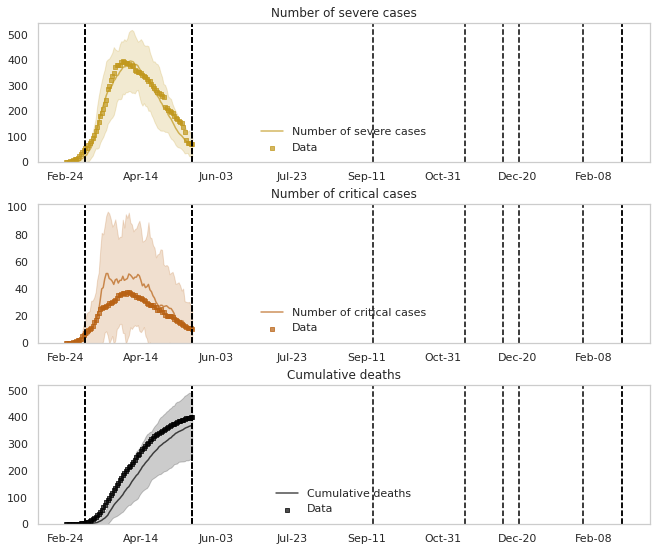

In [7]:
initial_params = {k[5:]: v for k, v in best_params.items() if k.startswith('init_')}
initial_params.update(default_params)

intervention_params = {k[7:]: v for k, v in best_params.items() if k.startswith('interv_')}
interventions = get_interventions(intervention_params)

sim = cv.Sim(pars=initial_params, interventions=interventions, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=30)

msim.mean()
msim.plot(cols);

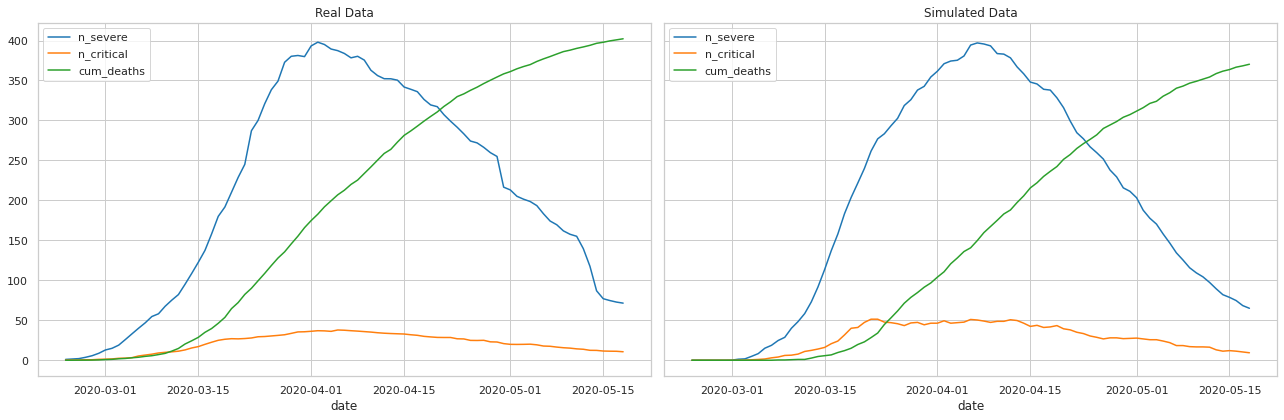

In [8]:
_, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for col in cols:
    sns.lineplot(data=df, x='date', y=col, label=col, ax=axes[0]).set(title='Real Data', ylabel='')
    sns.lineplot(data=msim.results, x='date', y=col, label=col, ax=axes[1]).set(title='Simulated Data', ylabel='')

plt.tight_layout()